## Pattern Based AI

In [1]:
# Rules: statement => expression | expressions
test_gram = """
sentence => noun_phrase verb_phrase
noun_phrase => Article Adj* noun
Adj* => Adj | Adj Adj*
verb_phrase => verb noun_phrase
Article =>  一个 | 这个
noun =>   女人 |  篮球 | 桌子 | 小猫
verb => 看着   |  坐在 |  听着 | 看见
Adj =>   蓝色的 |  好看的 | 小小的
"""

In [2]:
import random

# Get grammar dictionary
def get_gram_dict(gram_str: str, stmt_split='=>', or_split='|'):
    rules = dict() # key is stmt, value is expr
    
    for line in gram_str.split('\n'):
        if not line: continue # skip the empty line
        
        stmt, expr = line.split(stmt_split)
        
        rules[stmt.strip()] = [e.strip() for e in expr.split(or_split)]
    
    return rules

# Get target according to given rules
def generate(gram_rule, target):
    # if target in rules, return expr, else return itself
    if target in gram_rule:
        candidates = gram_rule[target]
        candidate = random.choice(candidates)
        return ''.join(generate(gram_rule, target=c.strip()) for c in candidate.split())
    else:
        return target


#### 之所以把rule生成器和target生成器分开，是为了在多次获取target时不需要重新生成rules，减少冗余

In [3]:
# test
test_rule = get_gram_dict(test_gram)

In [4]:
# test
generate(test_rule, 'sentence')

'这个小小的小猫坐在一个蓝色的桌子'

## Language Model

In [5]:
# 读取语料文件
corpus = 'article_9k.txt'
FILE = open(corpus).read()
print(len(FILE))

33425826


In [7]:
# 用jieba分词切分预料库
import jieba
max_length = 1000000 # 测试只用部分库
sub_file = FILE[:max_length]
TOKENS = list(jieba.cut(sub_file))
print(len(TOKENS))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/qn/yh63v8fn5fd2l36nndjc3tw80000gn/T/jieba.cache
Loading model cost 1.445 seconds.
Prefix dict has been built succesfully.


532454


In [9]:
# 观察一下正在使用的语料库的单词频次
from collections import Counter
words_count = Counter(TOKENS)
words_count.most_common(20)

[('的', 28764),
 ('在', 7563),
 ('了', 6529),
 ('是', 4883),
 ('和', 4245),
 ('也', 2531),
 ('月', 2433),
 ('有', 2374),
 ('将', 2114),
 ('他', 1960),
 ('年', 1959),
 ('对', 1795),
 ('都', 1720),
 ('中', 1699),
 ('为', 1686),
 ('日', 1674),
 ('等', 1655),
 ('与', 1601),
 ('中国', 1597),
 ('上', 1583)]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


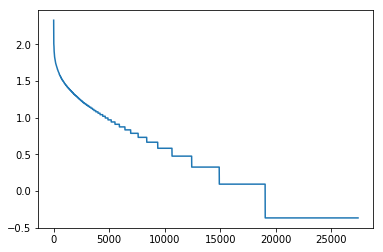

In [12]:
# 用2d图像来看一下频次分布情况
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
words_with_fre = [f for w, f in words_count.most_common()]
plt.plot(np.log(np.log(words_with_fre)));

## 建立2-gram model

In [14]:
# 获取单个词和两个词的list及count
one_words = TOKENS
two_words = [TOKENS[i] + TOKENS[i+1] for i in range(len(TOKENS)-1)]
one_count = Counter(one_words)
two_count = Counter(two_words)

In [15]:
# 获取频次的函数
def get_gram_count(word, wc):
    if word in wc: return wc[word]
    else:
        return wc.most_common()[-1][-1]

In [18]:
# two gram language model
def two_gram_model(sentence):
    tokens = list(jieba.cut(sentence)) # 先将传入参数分词
    
    probability = 1
    
    for i in range(len(tokens)-1):
        word = tokens[i]
        next_w = tokens[i+1]
        
        two_gram_c = get_gram_count(word+next_w, two_count)
        one_gram_c = get_gram_count(next_w, one_count)
        pro = two_gram_c / one_gram_c
        
        probability *= pro
    return probability

In [20]:
two_gram_model('冬天很热')

3.794778384942319e-05

In [21]:
two_gram_model('冬天很冷')

0.00022768670309653916

In [23]:
two_gram_model('')

8.237775141689733e-06